<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Sentiment-Analysis-with-an-RNN" data-toc-modified-id="Sentiment-Analysis-with-an-RNN-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Sentiment Analysis with an RNN</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Introduction</a></span></li></ul></li><li><span><a href="#Movie-Sentiment-Dataset-Downloading-to-a-Local-Folder" data-toc-modified-id="Movie-Sentiment-Dataset-Downloading-to-a-Local-Folder-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Movie Sentiment Dataset Downloading to a Local Folder</a></span></li></ul></li></ul></div>

# Sentiment Analysis with an RNN

(code is adopted from https://github.com/PacktPublishing/Mastering-PyTorch/blob/master/Chapter04/rnn.ipynb and some texts from https://github.com/bentrevett/pytorch-sentiment-analysis)

In this notebook, you'll implement a recurrent neural network that performs sentiment analysis.

Using an RNN rather than a strictly feedforward network is more accurate since we can include information about the sequence of words.

Here we'll use a dataset of movie reviews, accompanied by sentiment labels: positive or negative.

In [1]:
import os
import time
import numpy as np
!pip install tqdm
from tqdm import tqdm
from string import punctuation
from collections import Counter
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(123)

### Introduction

We'll be using a **recurrent neural network** (RNN) as they are commonly used in analysing sequences. An RNN takes in sequence of words, $X=\{x_1, ..., x_T\}$, one at a time, and produces a _hidden state_, $h$, for each word. We use the RNN _recurrently_ by feeding in the current word $x_t$ as well as the hidden state from the previous word, $h_{t-1}$, to produce the next hidden state, $h_t$. 

$$h_t = \text{RNN}(x_t, h_{t-1})$$

Once we have our final hidden state, $h_T$, (from feeding in the last word in the sequence, $x_T$) we feed it through a linear layer, $f$, (also known as a fully connected layer), to receive our predicted sentiment, $\hat{y} = f(h_T)$.

Below shows an example sentence, with the RNN predicting zero, which indicates a negative sentiment. The RNN is shown in orange and the linear layer shown in silver. Note that we use the same RNN for every word, i.e. it has the same parameters. The initial hidden state, $h_0$, is a tensor initialized to all zeros. 

![picture](http://drive.google.com/uc?export=view&id=1n6yofIlp0edQ9Gieor00RhgOQDrdPro7)

**Note:** some layers and steps have been omitted from the diagram, but these will be explained later.

## Movie Sentiment Dataset Downloading to a Local Folder
This is the IMDB Reviews Dataset

In [ ]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
import tarfile

print("Unzipping download file with reviews")
tar = tarfile.open("aclImdb_v1.tar.gz")
tar.extractall()
tar.close()

# read sentiments and reviews data from the text files
review_list = []
label_list = []
for label in ['pos', 'neg']:
    for fname in tqdm(os.listdir(f'./aclImdb/train/{label}/')):
        if 'txt' not in fname:
            continue
        with open(os.path.join(f'./aclImdb/train/{label}/', fname), encoding="utf8") as f:
            review_list += [f.read()]
            label_list += [label]
print ('\nNumber of reviews :', len(review_list))

--2020-12-28 23:46:51--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  63.4MB/s    in 1.3s    

2020-12-28 23:46:53 (63.4 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]

Unzipping download file with reviews


100%|██████████| 12500/12500 [00:00<00:00, 38609.38it/s]


Number of reviews : 25000


In [ ]:
# pre-processing review text
review_list = [review.lower() for review in review_list]
review_list = [''.join([letter for letter in review if letter not in punctuation]) for review in tqdm(review_list)]

# accumulate all review texts together
reviews_blob = ' '.join(review_list)

# generate list of all words of all reviews
review_words = reviews_blob.split()

# get the word counts
count_words = Counter(review_words)

# sort words as per counts (decreasing order)
total_review_words = len(review_words)
sorted_review_words = count_words.most_common(total_review_words)

print(sorted_review_words[:10])

100%|██████████| 25000/25000 [00:01<00:00, 13232.08it/s]


[('the', 334691), ('and', 162228), ('a', 161940), ('of', 145326), ('to', 135042), ('is', 106855), ('in', 93028), ('it', 77099), ('i', 75719), ('this', 75190)]


In [ ]:
# create word to integer (token) dictionary in order to encode text as numbers
vocab_to_token = {word:idx+1 for idx, (word, count) in enumerate(sorted_review_words)}
print(list(vocab_to_token.items())[:10])

[('the', 1), ('and', 2), ('a', 3), ('of', 4), ('to', 5), ('is', 6), ('in', 7), ('it', 8), ('i', 9), ('this', 10)]


In [ ]:
reviews_tokenized = []
for review in review_list:
    word_to_token = [vocab_to_token[word] for word in review.split()]
    reviews_tokenized.append(word_to_token)
print(review_list[0])
print()
print (reviews_tokenized[0])

i dont know what it is i find so endearing about this film but the first time i saw it i wanted to see how it ended im not a big fan of paul winfield nor of wardramas but i was truly wondering just how and when winfield would find his child all he knows is that the boy has green eyes truth be told i have not seen this movie in years nor has it been shown on tv in a while but this movie is somewhat of one mans odyssey after the pains of war winfield shows a very sympathetic and heart warming portrayal of a man lost by his memories there is an underlying message in this movie that he is looking for the last shred of human morality in the aftermath of this war and the reality that he does confront why this movie is not yet on dvd or video is a mystery to me

[9, 89, 117, 48, 8, 6, 9, 159, 37, 3208, 42, 10, 19, 18, 1, 85, 61, 9, 207, 8, 9, 452, 5, 67, 86, 8, 1044, 141, 21, 3, 194, 329, 4, 711, 18053, 859, 4, 57550, 18, 9, 13, 352, 1450, 40, 86, 2, 50, 18053, 58, 159, 24, 512, 31, 26, 668, 

In [ ]:
# encode sentiments as 0 or 1
encoded_label_list = [1 if label =='pos' else 0 for label in label_list]

reviews_len = [len(review) for review in reviews_tokenized]

reviews_tokenized = [reviews_tokenized[i] for i, l in enumerate(reviews_len) if l>0 ]
encoded_label_list = np.array([encoded_label_list[i] for i, l in enumerate(reviews_len) if l> 0 ], dtype='float32')

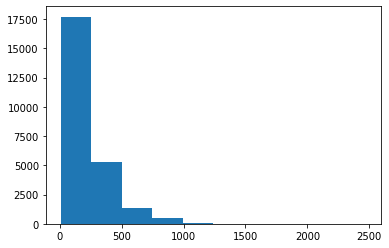

In [ ]:
def pad_sequence(reviews_tokenized, sequence_length):
    ''' returns the tokenized review sequences padded with 0's or truncated to the sequence_length.
    '''
    padded_reviews = np.zeros((len(reviews_tokenized), sequence_length), dtype = int)
    
    for idx, review in enumerate(reviews_tokenized):
        review_len = len(review)
        
        if review_len <= sequence_length:
            zeroes = list(np.zeros(sequence_length-review_len))
            new_sequence = zeroes+review
        elif review_len > sequence_length:
            new_sequence = review[0:sequence_length]
        
        padded_reviews[idx,:] = np.array(new_sequence)
    
    return padded_reviews

sequence_length = 512
padded_reviews = pad_sequence(reviews_tokenized=reviews_tokenized, sequence_length=sequence_length)

plt.hist(reviews_len);

In [ ]:
train_val_split = 0.75
train_X = padded_reviews[:int(train_val_split*len(padded_reviews))]
train_y = encoded_label_list[:int(train_val_split*len(padded_reviews))]
validation_X = padded_reviews[int(train_val_split*len(padded_reviews)):]
validation_y = encoded_label_list[int(train_val_split*len(padded_reviews)):]

In [ ]:
## If while training, you get a runtime error that says: "RuntimeError: Expected tensor for argument #1 'indices' to have scalar type Long".
## simply uncomment run the following lines of code additionally
# train_X = train_X.astype('int64')
# train_y = train_y.astype('int64')
# validation_X = validation_X.astype('int64')
# validation_y = validation_y.astype('int64')

In [ ]:
# generate torch datasets
train_dataset = TensorDataset(torch.from_numpy(train_X).to(device), torch.from_numpy(train_y).to(device))
validation_dataset = TensorDataset(torch.from_numpy(validation_X).to(device), torch.from_numpy(validation_y).to(device))


batch_size = 32
# torch dataloaders (shuffle data)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# get a batch of train data
train_data_iter = iter(train_dataloader)
X_example, y_example = train_data_iter.next()
print('Example Input size: ', X_example.size()) # batch_size, seq_length
print('Example Input:\n', X_example)
print()
print('Example Output size: ', y_example.size()) # batch_size
print('Example Output:\n', y_example)

Example Input size:  torch.Size([32, 512])
Example Input:
 tensor([[    0,     0,     0,  ...,    20, 14267,   678],
        [    0,     0,     0,  ...,  2287,  1934, 43333],
        [ 6475,    43,     3,  ...,     3,  2749,  1111],
        ...,
        [   28,     4,     1,  ...,     4,  1479, 21055],
        [    0,     0,     0,  ...,   485,    98,  2346],
        [    0,     0,     0,  ...,     4,   169,  1258]], device='cuda:0')

Example Output size:  torch.Size([32])
Example Output:
 tensor([0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1.],
       device='cuda:0')


In [ ]:
class RNN(nn.Module):
    def __init__(self, input_dimension, embedding_dimension, hidden_dimension, output_dimension):
        super().__init__()
        self.embedding_layer = nn.Embedding(input_dimension, embedding_dimension)  
        self.rnn_layer = nn.RNN(embedding_dimension, hidden_dimension, num_layers=1)
        self.fc_layer = nn.Linear(hidden_dimension, output_dimension)
        
    def forward(self, sequence):
        # sequence shape = (sequence_length, batch_size)
        embedding = self.embedding_layer(sequence)  
        # embedding shape = [sequence_length, batch_size, embedding_dimension]
        output, hidden_state = self.rnn_layer(embedding)
        # output shape = [sequence_length, batch_size, hidden_dimension]
        # hidden_state shape = [1, batch_size, hidden_dimension]
        final_output = self.fc_layer(hidden_state[-1,:,:].squeeze(0))      
        return final_output
    
input_dimension = len(vocab_to_token)+1 # +1 to account for padding
embedding_dimension = 100
hidden_dimension = 32
output_dimension = 1

rnn_model = RNN(input_dimension, embedding_dimension, hidden_dimension, output_dimension)

optim = torch.optim.Adam(rnn_model.parameters())
loss_func = nn.BCEWithLogitsLoss()

rnn_model = rnn_model.to(device)
loss_func = loss_func.to(device)

In [ ]:
def accuracy_metric(predictions, ground_truth):
    """
    Returns 0-1 accuracy for the given set of predictions and ground truth
    """
    # round predictions to either 0 or 1
    rounded_predictions = torch.round(torch.sigmoid(predictions))
    success = (rounded_predictions == ground_truth).float() #convert into float for division 
    accuracy = success.sum() / len(success)
    return accuracy

In [ ]:
def train(model, dataloader, optim, loss_func):
    loss = 0
    accuracy = 0
    model.train()
    
    for sequence, sentiment in dataloader:
        optim.zero_grad()     
        preds = model(sequence.T).squeeze()
        
        loss_curr = loss_func(preds, sentiment)
        accuracy_curr = accuracy_metric(preds, sentiment)
        
        loss_curr.backward()
        optim.step()
        
        loss += loss_curr.item()
        accuracy += accuracy_curr.item()
        
    return loss/len(dataloader), accuracy/len(dataloader)

In [ ]:
def validate(model, dataloader, loss_func):
    loss = 0
    accuracy = 0
    model.eval()
    
    with torch.no_grad():
        for sequence, sentiment in dataloader:
            
            preds = model(sequence.T).squeeze()
            
            loss_curr = loss_func(preds, sentiment)   
            accuracy_curr = accuracy_metric(preds, sentiment)

            loss += loss_curr.item()
            accuracy += accuracy_curr.item()
        
    return loss/len(dataloader), accuracy/len(dataloader)

In [ ]:
num_epochs = 10
best_validation_loss = float('inf')

for ep in range(num_epochs):

    time_start = time.time()
    
    training_loss, train_accuracy = train(rnn_model, train_dataloader, optim, loss_func)
    validation_loss, validation_accuracy = validate(rnn_model, validation_dataloader, loss_func)
    
    time_end = time.time()
    time_delta = time_end - time_start  
    
    if validation_loss < best_validation_loss:
        best_validation_loss = validation_loss
        torch.save(rnn_model.state_dict(), 'rnn_model.pt')
    
    print(f'epoch number: {ep+1} | time elapsed: {time_delta}s')
    print(f'training loss: {training_loss:.3f} | training accuracy: {train_accuracy*100:.2f}%')
    print(f'validation loss: {validation_loss:.3f} |  validation accuracy: {validation_accuracy*100:.2f}%')
    print()

epoch number: 1 | time elapsed: 14.243398427963257s
training loss: 0.619 | training accuracy: 66.86%
validation loss: 0.899 |  validation accuracy: 36.22%

epoch number: 2 | time elapsed: 14.03232741355896s
training loss: 0.528 | training accuracy: 74.46%
validation loss: 0.989 |  validation accuracy: 34.98%

epoch number: 3 | time elapsed: 14.05145525932312s
training loss: 0.433 | training accuracy: 80.65%
validation loss: 0.814 |  validation accuracy: 58.15%

epoch number: 4 | time elapsed: 14.11315107345581s
training loss: 0.346 | training accuracy: 85.77%
validation loss: 0.790 |  validation accuracy: 62.11%

epoch number: 5 | time elapsed: 14.052831411361694s
training loss: 0.309 | training accuracy: 87.44%
validation loss: 1.016 |  validation accuracy: 58.05%

epoch number: 6 | time elapsed: 14.01461410522461s
training loss: 0.259 | training accuracy: 89.98%
validation loss: 1.005 |  validation accuracy: 59.78%

epoch number: 7 | time elapsed: 14.282076835632324s
training loss: 0

In [ ]:
def sentiment_inference(model, sentence):
    model.eval()
    
    # text transformations
    sentence = sentence.lower()
    sentence = ''.join([c for c in sentence if c not in punctuation])
    tokenized = [vocab_to_token.get(token, 0) for token in sentence.split()]
    tokenized = np.pad(tokenized, (512-len(tokenized), 0), 'constant')
    
    # model inference
    model_input = torch.LongTensor(tokenized).to(device)
    model_input = model_input.unsqueeze(1)
    pred = torch.sigmoid(model(model_input))
    
    return pred.item()

In [ ]:
print(sentiment_inference(rnn_model, "This film is horrible"))
print(sentiment_inference(rnn_model, "Director tried too hard but this film is bad"))
print(sentiment_inference(rnn_model, "Decent movie, although could be shorter"))
print(sentiment_inference(rnn_model, "This film will be houseful for weeks"))
print(sentiment_inference(rnn_model, "I loved the movie, every part of it"))

0.004703204613178968
0.005312444642186165
0.10777481645345688
0.7247500419616699
0.2506076395511627


In [ ]:
print(sentiment_inference(rnn_model, "I liked the movie a lot"))

0.6335980892181396
